# User prompt
The user define the research objective a prompt. I use openAI to identify relevant key words for the research.
Documentation:
* https://platform.openai.com/docs/guides/text?api-mode=responses&lang=python

In [ ]:
#  I'm working with a client looking to understand the potential use of silicone based products for soft contact lenses. 

In [1]:
import os
from dotenv import load_dotenv
from openai import OpenAI
from openai.types.responses import Response

# Load the API key
load_dotenv()

client: OpenAI = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Research objective
research_objective: str = """
At present, one of our clients is looking to speak with professionals who have insights about the emerging technologies 
in soft contact lens manufacturing, particularly non-injection moulded methods. They would broadly like to understand how 
these technologies are reshaping the industry—from on-demand manufacturing to smart, drug-delivery-enabled lenses.
"""
# TODO: improve the prompt to extract words from the research objective. Problem:output variability
prompt: str = f"""
You are assisting a researcher in generating targeted search terms for academic and patent literature related to the research topic described below.

Return a JSON object with the following structure:
- "main_topic": a concise list with one element of words (2–3 words) extracted from the Research Objective that reflects the core technological focus
- "openalex": exactly 5 academic search terms, extracted from the Research Objective that reflects the client objective
- "patentview": exactly 1 patent-related single keywords, extrapolated from the Research Objective that reflects the client objective
- "cpc_codes": exactly 5 valid CPC classification codes relevant to the topic

Instructions:
- Output must be valid JSON only — no markdown, comments, or extra text
- All terms in "openalex" and "patentview" must be single or double words
- Do NOT include any words or close variants from "main_topic" in "openalex" or "patentview"
- All terms across the fields must be unique — no repetition or synonyms
- Each term in "openalex" and "patentview" must be conceptually compatible with the "main_topic" so that combining them (e.g. "main_topic" AND "keyword") produces a realistic and meaningful research query
- Use language and terminology commonly found in scientific publications and patent documents

Research Objective:
\"\"\" 
{research_objective} 
\"\"\"
"""

# Availables models: https://platform.openai.com/docs/pricing
GPT_MODEL = "gpt-4o-mini"

response: Response = client.responses.create(

    model=GPT_MODEL,
    input = prompt
)

print(f"The lenght of research objective is: {len(research_objective)}")

# print(type(response))
print(response.output_text)

The lenght of research objective is: 360
{
  "main_topic": ["soft contact lenses"],
  "openalex": [
    "non-injection methods",
    "on-demand production",
    "smart lenses",
    "drug delivery",
    "emerging technologies"
  ],
  "patentview": "manufacturing",
  "cpc_codes": [
    "A61F2/00",
    "B29C63/00",
    "B29D99/00",
    "C09J187/00",
    "G02C7/04"
  ]
}


In [4]:
import json

# Print the main topic
research_key_words: list[str]= json.loads(response.output_text)
print(research_key_words["main_topic"])
# print(research_key_words["openalex"][0])

['soft contact lenses']


# Openalex API
https://docs.openalex.org/

OpenAlex API: Valid Parameters

Pagination & Navigation
- `cursor`
- `page`
- `per_page`, `per-page`

Filtering & Searching
- `filter`
- `search`
- `q`
- `sample`
- `seed`

Grouping & Aggregation
- `group_by`, `group-by`
- `group_bys`, `group-bys`

Sorting & Selection
- `sort`
- `select`

Metrics
- `apc_sum`
- `cited_by_count_sum`

Other
- `mailto`
- `format`
- `warm`


## Loading papers

### Config & Constants

In [30]:
OPENALEX_URL = "https://api.openalex.org/works"
MAILTO = "adyl.elguamra@gmail.com"
PER_PAGE = 5
PAGE = 1

### Basic research query

In [45]:
import requests
import pandas as pd

params =  {
    "search": "contact lens manufacturing",
    "per_page": PER_PAGE,
    "page": PAGE,
    "sort": "relevance_score:desc",
    "mailto": "adyl.elguamra@gmail.com"
}

response = requests.get(OPENALEX_URL, params=params)
# print(response.json())

data = response.json()

data = response.json()


# Pretty-print the JSON data
print(json.dumps(data, indent=4))

{
    "meta": {
        "count": 108966,
        "db_response_time_ms": 266,
        "page": 1,
        "per_page": 5,
        "groups_count": null
    },
    "results": [
        {
            "id": "https://openalex.org/W2533308847",
            "doi": "https://doi.org/10.1097/icl.0000000000000335",
            "title": "Daily Wear Contact Lenses Manufactured in Etafilcon A Are Noninferior to Two Silicone Hydrogel Lens Types With Respect to Hypoxic Stress",
            "display_name": "Daily Wear Contact Lenses Manufactured in Etafilcon A Are Noninferior to Two Silicone Hydrogel Lens Types With Respect to Hypoxic Stress",
            "relevance_score": 387.04816,
            "publication_year": 2016,
            "publication_date": "2016-10-21",
            "ids": {
                "openalex": "https://openalex.org/W2533308847",
                "doi": "https://doi.org/10.1097/icl.0000000000000335",
                "mag": "2533308847",
                "pmid": "https://pubmed.ncbi.nlm.

In [ ]:
# Extract results into DataFrame
if "results" in data:
    openalex_df = pd.DataFrame(data["results"])
    print(openalex_df)
else:
    print("No results found or unexpected response format.")


### Abstract utility

In [ ]:
def reconstruct_abstract(abstract_inverted_index: dict[str, list[int]]) -> str:
    '''
    Reconstruct the abstract from abstract_inverted_index
    '''
    
    # Some works don't have an abstract
    if not abstract_inverted_index:
        return ""
        
    # Variable to store the highest index
    max_value: int = 0
     # Loop through all the list of position in the abstract_inverted_index dictionary.
    for values in abstract_inverted_index.values():
        # Loop through all the index value
        for value in values:
            # identify the highest value index
            if value >= max_value:
                max_value = value
                
    # Create an empty list with abstract size        
    abstract: list[str] = [None] * (max_value +1)

    # Loop through each word in the abstract_inverted_index:
    for word, positions in abstract_inverted_index.items():
        # For each word, get the list of positions it appears in.
        for position in positions:
            # Insert each word into its correct position in the list.
            abstract[position]= word
                        
    # Join all the words in the list into a single string, separated by spaces.
    # abstract_text: str = " ".join(abstract)
    abstract_text: str = " ".join(word if word is not None else "" for word in abstract)

    # print("\n", abstract_text)
    
    return abstract_text

### Data Extraction Logic

In [ ]:
from typing import Any
import requests

# TODO: refactor
def extract_authors(authorships: list[dict[str, Any]]) -> list[str]:
    return [a["author"]["display_name"] for a in authorships]

# TODO: refactors
def extract_institution_and_country(authorships: list[dict[str, Any]]) -> tuple[str | None, str | None]:
    if not authorships:
        return None, None
    institutions = authorships[0].get("institutions", [])
    if institutions:
        return institutions[0].get("display_name"), institutions[0].get("country_code")
    return None, None


def build_search_params(main_topic: str, keyword: str) -> dict[str, Any]:
    return {
        "search": f"({main_topic} AND {keyword})",
        "per_page": PER_PAGE,
        "page": PAGE,
        "sort": "relevance_score:desc",
        "mailto": MAILTO
    }
    
def fetch_openalex_records(main_topic: str, keywords: list[str]) -> list[dict[str, Any]]:
    all_records = []

    for keyword in keywords:
        params = build_search_params(main_topic, keyword)
        response = requests.get(OPENALEX_URL, params=params)
        print("Final URL:", response.url)

        if response.status_code != 200:
            print(f"Failed for keyword '{keyword}'. Status: {response.status_code}")
            print(response.text)
            continue

        data = response.json()
        for work in data.get("results", []):
            abstract = reconstruct_abstract(work.get("abstract_inverted_index", {}))
            authors = extract_authors(work.get("authorships", []))
            institution, country = extract_institution_and_country(work.get("authorships", []))

            record = {
                "keyword": keyword,
                "title": work.get("title"),
                "abstract": abstract,
                "publication_date": work.get("publication_date"),
                "year": work.get("publication_year"),
                "citations": work.get("cited_by_count"),
                "authors": authors,
                "institution": institution,
                "country": country,
                "openAlex_id": work.get("id"),
            }
            all_records.append(record)

    return all_records

### Openalex research

In [30]:
import pandas as pd
main_topic = research_key_words["main_topic"]
all_keywords = research_key_words["openalex"]

records = fetch_openalex_records(main_topic, all_keywords)
df = pd.DataFrame(records)

print(f"\nDataFrame shape: {df.shape}")
df[["keyword", "title", "publication_date", "authors", "country"]].head()


Final URL: https://api.openalex.org/works?search=%28%5B%27soft+contact+lenses%27%5D+AND+on-demand+manufacturing%29&per_page=5&page=1&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com
Final URL: https://api.openalex.org/works?search=%28%5B%27soft+contact+lenses%27%5D+AND+drug+delivery%29&per_page=5&page=1&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com
Final URL: https://api.openalex.org/works?search=%28%5B%27soft+contact+lenses%27%5D+AND+smart+lenses%29&per_page=5&page=1&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com
Final URL: https://api.openalex.org/works?search=%28%5B%27soft+contact+lenses%27%5D+AND+manufacturing+techniques%29&per_page=5&page=1&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com
Final URL: https://api.openalex.org/works?search=%28%5B%27soft+contact+lenses%27%5D+AND+emerging+technologies%29&per_page=5&page=1&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com

DataFrame shape: (25, 10)


,keyword,title,publication_date,authors,country
0,on-demand manufacturing,The Economics of Organization: The Transaction Cost Approach,1981-11-01,[Oliver E. Williamson],None
1,on-demand manufacturing,Biomedical applications of hydrogels: A review of patents and commercial products,2014-11-29,"[Enrica Caló, Vitaliy V. Khutoryanskiy]",GB
2,on-demand manufacturing,Managing Strategic Contradictions: A Top Management Model for Managing Innovation Streams,2005-10-01,"[Wendy K. Smith, Michael L. Tushman]",US
3,on-demand manufacturing,Soft contact lens polymers: an evolution,2001-12-01,"[Paul C. Nicolson, J. Vogt]",None
4,on-demand manufacturing,Fundamentals and applications of 3D printing for novel materials,2017-03-21,"[Jian‐Yuan Lee, Jia An, Chee Kai Chua]",SG


## Identify relevant papers

Documentation:
* https://python.langchain.com/docs/tutorials/rag/#overview 
* https://scalexi.medium.com/implementing-a-retrieval-augmented-generation-rag-system-with-openais-api-using-langchain-ab39b60b4d9f
* https://platform.openai.com/docs/guides/embeddings
* https://python.langchain.com/docs/tutorials/retrievers/
* https://cookbook.openai.com/examples/get_embeddings_from_dataset

In [15]:
# Create a new column: that combines the title and abstract into a single `text` field for each paper.
df["text"] = df["title"] + ". " + df["abstract"]
# Create a new column: will inform if the paper is relevant or not
df["relevant"] = ""
# Create a new column: will provide the relevance justification
df["justification"] = ""
# Print first rows of dataframe
print(df[["title", "publication_date", "country", "institution"]].head(10))
# print the shape
print("Dataframe shape:",df.shape)

                                               title publication_date country  \
0  The Economics of Organization: The Transaction...       1981-11-01    None   
1  Biomedical applications of hydrogels: A review...       2014-11-29      GB   
2  Managing Strategic Contradictions: A Top Manag...       2005-10-01      US   
3           Soft contact lens polymers: an evolution       2001-12-01    None   
4  Fundamentals and applications of 3D printing f...       2017-03-21      SG   
5  Biomedical applications of hydrogels: A review...       2014-11-29      GB   
6  Soft Contact Lenses as Drug Delivery Systems: ...       2021-09-14      PL   
7  Soft contact lenses functionalized with pendan...       2008-12-07      ES   
8         Drug delivery through soft contact lenses.       1988-02-01    None   
9  Surfactant-laden soft contact lenses for exten...       2008-11-18      US   

                              institution  
0                                    None  
1                   

In [16]:
import pandas as pd

def get_justification(title, abstract, objective):
    prompt = f"""
    You are the CEO, as well as a scientific and regulatory analyst, evaluating academic research for a company .

    Below is a paper's title and abstract, followed by the company's research objective. 
    
    Title:  
    {title}

    Abstract:  
    {abstract}

    Research Objective:  
    {objective}

    Assess if the paper is relevant. Start the answer with Yes or No, followed by a 1–2 sentence explanation based only on the title and abstract. 
    Be concise, specific, and fact-based. Avoid speculation or vague generalizations.
    """

    # print("Generating GPT justifications...")
    
    try:
        response: Response = client.responses.create(
        model=GPT_MODEL,
        input = prompt
        )
        return response.output_text
    except Exception as e:
        return f"ERROR: {e}"
    
def process_row(row: pd.Series) -> pd.Series:
    output = get_justification(row["title"], row["abstract"], research_objective)
    output_lower = output.lower()
    
    if output_lower.startswith("yes"):
        relevant = "yes"
    elif output_lower.startswith("no"):
        relevant = "no"
    else:
        relevant = "unclear"
        
    return pd.Series({"relevant": relevant, "justification": output})

# Apply the function to the entire DataFrame
df[["relevant", "justification"]] = df.apply(process_row, axis=1)

In [17]:
# Show full column contents and more columns
pd.set_option("display.max_colwidth", None)    # Show full text in cells

print(len(df[df["relevant"]=="yes"]))
df[df["relevant"]=="yes"][["title","keyword","country", "institution", "publication_date", "justification"]].head(15)

14


,title,keyword,country,institution,publication_date,justification
1,Biomedical applications of hydrogels: A review of patents and commercial products,on-demand manufacturing,GB,University of Reading,2014-11-29,"Yes, the paper is relevant as it discusses the applications of hydrogels, including their use in contact lenses, and highlights advancements in hydrogel technology. The focus on biomedical applications and innovations aligns well with the client's interest in emerging technologies for soft contact lens manufacturing."
5,Biomedical applications of hydrogels: A review of patents and commercial products,drug delivery,GB,University of Reading,2014-11-29,"Yes, the paper is relevant because it discusses the biomedical applications of hydrogels, which include their use in contact lenses. The focus on hydrogel characteristics and innovations aligns with the client's interest in emerging technologies for soft contact lens manufacturing."
6,Soft Contact Lenses as Drug Delivery Systems: A Review,drug delivery,PL,Adam Mickiewicz University in Poznań,2021-09-14,"Yes, the paper is relevant as it discusses the role of soft contact lenses as drug delivery systems, aligning with the client's interest in emerging technologies in contact lens manufacturing. The review's focus on innovative methods for enhancing drug delivery through lenses could inform insights on advances in manufacturing techniques and applications."
7,Soft contact lenses functionalized with pendant cyclodextrins for controlled drug delivery,drug delivery,ES,Universidade de Santiago de Compostela,2008-12-07,"Yes, the paper is relevant as it addresses the functionalization of soft contact lenses with cyclodextrins for controlled drug delivery, aligning with the client's interest in emerging technologies that focus on enhanced functionalities in soft contact lens manufacturing. The focus on innovative drug delivery systems in contact lenses suggests potential advancements in the industry."
9,Surfactant-laden soft contact lenses for extended delivery of ophthalmic drugs,drug delivery,US,University of Florida,2008-11-18,"Yes, the paper is relevant as it discusses surfactant-laden soft contact lenses specifically designed for drug delivery, aligning with the client's interest in technologies that enhance functional capabilities in soft contact lenses, including drug delivery systems."
10,"Soft, smart contact lenses with integrations of wireless circuits, glucose sensors, and displays",smart lenses,KR,Ulsan National Institute of Science and Technology,2018-01-05,"Yes, the paper is relevant as it discusses advancements in soft, smart contact lenses that integrate wireless circuits and sensors, specifically targeting real-time diabetes monitoring, which aligns with emerging technologies in contact lens manufacturing and smart lens applications."
11,Wearable smart sensor systems integrated on soft contact lenses for wireless ocular diagnostics,smart lenses,KR,Ulsan National Institute of Science and Technology,2017-04-27,"Yes, the paper is relevant as it discusses a multifunctional smart contact lens that integrates sensor technology for monitoring physiological parameters, aligning with the focus on emerging technologies in soft contact lens manufacturing. Additionally, the exploration of wireless ocular diagnostics and simultaneous analyte detection could inform advancements in drug-delivery-enabled lenses."
12,"Smart, soft contact lens for wireless immunosensing of cortisol",smart lenses,KR,Yonsei University,2020-07-08,"Yes, the paper is relevant as it discusses a novel smart contact lens that utilizes advanced technology for health monitoring, specifically focusing on non-invasive cortisol detection. This aligns with the client's interest in emerging technologies within soft contact lens manufacturing, particularly regarding smart capabilities."
13,"Printing of wirelessly rechargeable solid-state supercapacitors for soft, smart contact lenses with continuous operations",smart

## Openalex: trends in relevant papers
* Track the number of papers per year — increasing output indicates a growing area.
* Frequent authors or groups often signal thought leadership.
* Which countries, universities, or labs are publishing the most?
* Are there regional clusters or shifts in research activity?



In [18]:
oa_trends_df = df[df["relevant"]=="yes"].copy()
oa_trends_df[["title","keyword","country", "institution", "publication_date", "justification"]].head()

,title,keyword,country,institution,publication_date,justification
1,Biomedical applications of hydrogels: A review of patents and commercial products,on-demand manufacturing,GB,University of Reading,2014-11-29,"Yes, the paper is relevant as it discusses the applications of hydrogels, including their use in contact lenses, and highlights advancements in hydrogel technology. The focus on biomedical applications and innovations aligns well with the client's interest in emerging technologies for soft contact lens manufacturing."
5,Biomedical applications of hydrogels: A review of patents and commercial products,drug delivery,GB,University of Reading,2014-11-29,"Yes, the paper is relevant because it discusses the biomedical applications of hydrogels, which include their use in contact lenses. The focus on hydrogel characteristics and innovations aligns with the client's interest in emerging technologies for soft contact lens manufacturing."
6,Soft Contact Lenses as Drug Delivery Systems: A Review,drug delivery,PL,Adam Mickiewicz University in Poznań,2021-09-14,"Yes, the paper is relevant as it discusses the role of soft contact lenses as drug delivery systems, aligning with the client's interest in emerging technologies in contact lens manufacturing. The review's focus on innovative methods for enhancing drug delivery through lenses could inform insights on advances in manufacturing techniques and applications."
7,Soft contact lenses functionalized with pendant cyclodextrins for controlled drug delivery,drug delivery,ES,Universidade de Santiago de Compostela,2008-12-07,"Yes, the paper is relevant as it addresses the functionalization of soft contact lenses with cyclodextrins for controlled drug delivery, aligning with the client's interest in emerging technologies that focus on enhanced functionalities in soft contact lens manufacturing. The focus on innovative drug delivery systems in contact lenses suggests potential advancements in the industry."
9,Surfactant-laden soft contact lenses for extended delivery of ophthalmic drugs,drug delivery,US,University of Florida,2008-11-18,"Yes, the paper is relevant as it discusses surfactant-laden soft contact lenses specifically designed for drug delivery, aligning with the client's interest in technologies that enhance functional capabilities in soft contact lenses, including drug delivery systems."


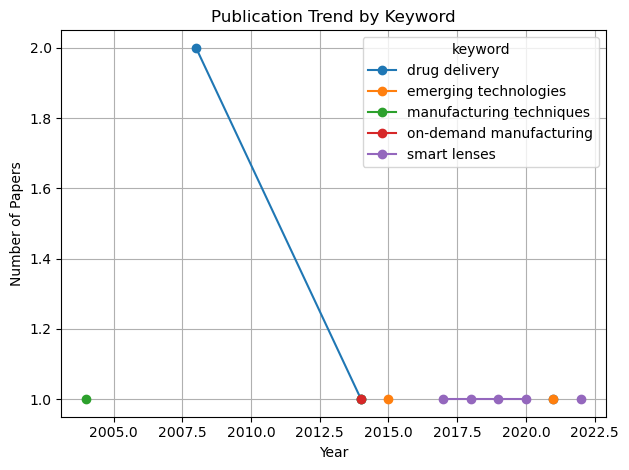

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

oa_trends_df['year'] = pd.to_datetime(oa_trends_df['publication_date']).dt.year

oa_trends_df.groupby(['year', 'keyword']).size().unstack().plot(
    kind='line',
    marker='o',
    title='Publication Trend by Keyword'
)
plt.ylabel('Number of Papers')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()
plt.show()

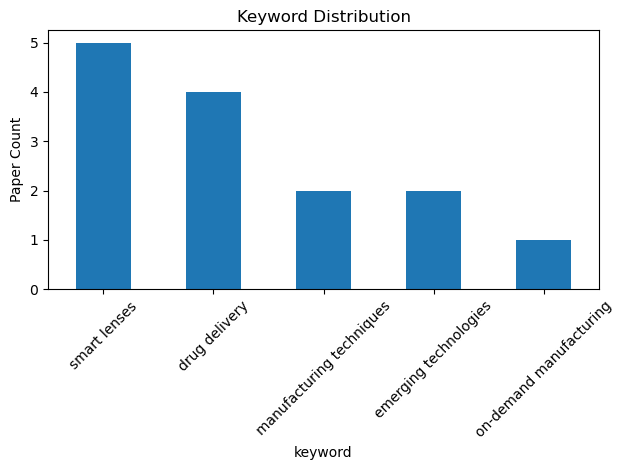

In [20]:
oa_trends_df['keyword'].value_counts().plot(
    kind='bar',
    title='Keyword Distribution',
    ylabel='Paper Count'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


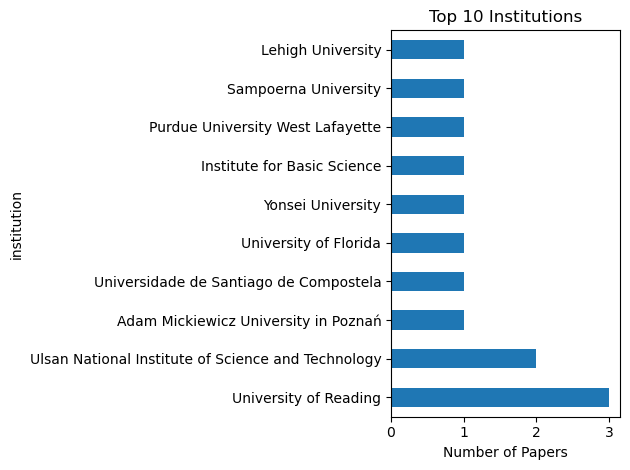

In [21]:
oa_trends_df['institution'].value_counts().head(10).plot(
    kind='barh',
    title='Top 10 Institutions',
    xlabel='Number of Papers'
)
plt.tight_layout()
plt.show()


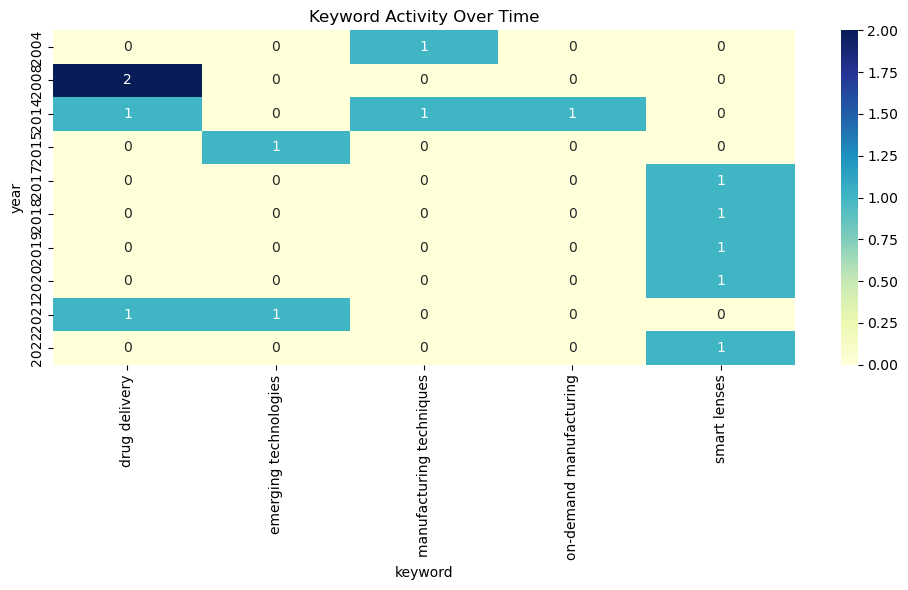

In [22]:
import seaborn as sns

heatmap_data = (
    oa_trends_df.groupby(['year', 'keyword'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Keyword Activity Over Time")
plt.tight_layout()
plt.show()


# Patentview API
https://patentsview.org/apis/purpose
The current version of the new PatentSearch API delivers data on patents granted through March 31, 2025.

https://github.com/PatentsView/PatentsView-Code-Examples/tree/main

https://github.com/PatentsView/PatentsView-Code-Examples/blob/main/data-downloads/0-getting-started.ipynb

## Loading data

### Config and constants

In [ ]:
import requests
import pandas as pd
from dotenv import load_dotenv
import os

# Load API key
load_dotenv()
PATENTVIEW_API_KEY = os.getenv("PATENTSVIEW_API_KEY")


# Endpoint and headers
PATENTVIEW_URL = "https://search.patentsview.org/api/v1/patent" # url = "https://search.patentsview.org/api/v1/patent"
HEADERS = {
    "X-Api-Key": PATENTVIEW_API_KEY,
    "Content-Type": "application/json"
}


### Test simple query
https://search.patentsview.org/swagger-ui/

In [36]:
import requests
import json

patentview_params = {
    "q": '''
        {
            "_and": [
                {"_text_phrase": {"patent_title": "contact lens"}},
                {"_text_phrase": {"patent_title": "manufacturing"}}
            ]
        }
    ''',
    "f": '["patent_id", "patent_title", "patent_date", "patent_abstract", "applicants", "application", "assignees", "attorneys", "cpc_current"]', # https://search.patentsview.org/docs/docs/Search%20API/EndpointDictionary
    "o": '{"size": 50, "exclude_withdrawn": true}',
    "s": '[{"patent_date": "desc"}]'
}

response = requests.get(PATENTVIEW_URL, headers=HEADERS, params=patentview_params)
# print(re§sponse.json())

data = response.json()


# Pretty-print the JSON data
print(json.dumps(data, indent=4))

{
    "error": false,
    "count": 50,
    "total_hits": 58,
    "patents": [
        {
            "patent_id": "12240949",
            "patent_title": "Material for manufacturing contact lenses and contact lens thereof",
            "patent_date": "2025-03-04",
            "patent_abstract": "A material for manufacturing contact lenses comprises a first composition, a second composition, at least one hydrophilic monomer and at least one photoinitiator. The first composition and the second composition are respectively represented by the following formula (1) and formula (2).Z1 is a first silicone hydrogel monomer, n1 is ranged between 1 and 1.5, and o1 is ranged between 1 and 2; and Z2 is a second silicone hydrogel monomer, n2 is ranged between 1 and 5, and o2 is ranged between 1 and 2.",
            "application": [
                {
                    "application_id": "17/344166",
                    "application_type": "17",
                    "filing_date": "2021-06-10",
      

In [33]:
# Extract results into DataFrame
if "patents" in data:
    df = pd.DataFrame(data["patents"])
    df["applicant_organization"]= df["applicants"].apply(lambda x: x[0]["applicant_organization"] if isinstance(x, list) else None) # truthy
    print(df[["patent_title","patent_date", "applicants","applicant_organization"]])
else: 
    print("No results found or unexpected response format.")

                                                                                                                                                      patent_title  \
0                                                                                               Material for manufacturing contact lenses and contact lens thereof   
1                                                                                                                  Specialty contact lens design and manufacturing   
2                                                                                        Method of manufacturing contact lens for treating color vision deficiency   
3                                                                    Partially cured contact lens-type amniotic membrane dressing and method of manufacturing same   
4                                                                  Colored contact lens, manufacturing method of colored contact lens, and iris recognition system   
5   

In [28]:
df.head(50)

,patent_id,patent_title,patent_date,patent_abstract,applicants,applicant_organization
0,12240949,Material for manufacturing contact lenses and contact lens thereof,2025-03-04,"A material for manufacturing contact lenses comprises a first composition, a second composition, at least one hydrophilic monomer and at least one photoinitiator. The first composition and the second composition are respectively represented by the following formula (1) and formula (2).Z1 is a first silicone hydrogel monomer, n1 is ranged between 1 and 1.5, and o1 is ranged between 1 and 2; and Z2 is a second silicone hydrogel monomer, n2 is ranged between 1 and 5, and o2 is ranged between 1 and 2.","[{'applicant_name_first': None, 'applicant_name_last': None, 'applicant_organization': 'INNO VISION CORP.', 'applicant_sequence': 1, 'applicant_designation': 'us-only', 'applicant_type': 'applicant', 'location_id': 'b5c9a039-16c7-11ed-9b5f-1234bde3cd05'}]",INNO VISION CORP.
1,12169329,Specialty contact lens design and manufacturing,2024-12-17,"Specialty contact lenses can be designed using approximations of one or both surfaces using mathematical representations. The approximations can be configured to optimize the lens manufacturing process. Constraints can be applied to the approximation to achieve the targeted results. The constraints can be assigned based at least in part on labels applied to measurements of the eye. Lens fit parameters can also be applied to control the degree to which the approximation approaches perfectly matching a targeted shape (e.g., the topography of the patient's eye). For example, the lens fit parameter can be related to the order of the mathematical representation used in the approximation. The contact lenses designed and manufactured using the methods and systems disclosed herein can be of any suitable type including, but not limited to, scleral lenses.","[{'applicant_name_first': None, 'applicant_name_last': None, 'applicant_organization': 'Hedgefog Research, Inc.', 'applicant_sequence': 1, 'applicant_designation': 'us-only', 'applicant_type': 'applicant', 'location_id': 'c7aa7e7f-16c7-11ed-9b5f-1234bde3cd05'}]","Hedgefog Research, Inc."
2,12140820,Method of manufacturing contact lens for treating color vision deficiency,2024-11-12,"A method of forming an ophthalmic contact lens using an additive manufacturing apparatus is presented herein. The method providing a first solution comprising HEMA, PEGDA, and a photoinitiator, forming a support structure on a planar print bed of the additive manufacturing apparatus by depositing a first plurality of layers of the first solution and curing the first plurality of layers, and forming an ophthalmic contact lens on the support structure by depositing a second plurality of layers of the first solution and curing the second plurality of layers. The second plurality of layers are arranged such that a disc of the ophthalmic contact lens is oriented generally perpendicular to the planar print bed of the additive manufacturing apparatus.","[{'applicant_name_first': None, 'applicant_name_last': None, 'applicant_organization': 'Khalifa University of Science and Technology', 'applicant_sequence': 1, 'applicant_designation': 'us-only', 'applicant_type': 'applicant', 'location_id': '40a54e1c-16c8-11ed-9b5f-1234bde3cd05'}]",Khalifa University of Science and Technology
3,12064529,Partially cured contact lens-type amniotic membrane dressing and method of manufacturing same,2024-08-20,"The present invention relates to a contact lens-type dressing manufactured by using a partially cured amniotic membrane dressing and a method of manufacturing same. The method of manufacturing a partially cured contact lens-type amniotic membrane dressing, and the partially cured contact lens-type amniotic membrane dressing of the present invention have a simple manufacturing method, can produce a contact lens-type amniotic membrane without foreign matter, have excellent biocompatibility, have excellent lens compatibi

In [ ]:
import requests

PATENTVIEW_URL = "https://search.patentsview.org/api/v1/patent"
# PATENTVIEW_URL = "https://api.patentsview.org/patents/query"



PATENTVIEW_HEADERS = {
    "X-Api-Key": API_KEY, 
    "Content-Type": "application/json"
}

test_query = {
    "q": {
        "_and": [
            {
                "_or": [
                    {"_text_phrase": {"patent_title": "contact lens"}},
                    {"_text_phrase": {"patent_abstract": "contact lens"}}
                ]
            },
            {
                "_or": [
                    {"_text_phrase": {"patent_title": "fabrication"}},
                    {"_text_phrase": {"patent_abstract": "fabrication"}}
                ]
            }
        ]
    },
    "f": ["patent_id", "patent_title", "patent_date", "patent_abstract"],
    "o": {"per_page": 5, "page": 1}
}

# Send request
response = requests.post(PATENTVIEW_URL, json=test_query, headers=PATENTVIEW_HEADERS)

response.json()
# # Handle response
# print("Status code:", response.status_code)
# if response.status_code == 200:
#     data = response.json()
#     if data.get("patents"):
#         print("Sample result:", data["patents"][0])
#     else:
#         print("No patents found for this query.")
# else:
#     print("Error response:", response.text)


{'error': True, 'reason': 'discontinued'}

### Data Extraction Logic

In [85]:
# Collect results here
all_patents = []

main_topic = research_key_words["main_topic"]
all_keywords = research_key_words["patentview"]


for keyword in all_keywords:
    combined_text = f"{main_topic} {keyword}"
    
    query = {
        "q": {
            "_text_all": {
                "patent_title": combined_text,
                "patent_abstract": combined_text
            }
        },
        "f": [
            "patent_title",
            "patent_abstract",
            "patent_date",
            "inventors.inventor_name_first",
            "inventors.inventor_name_last",
            "assignees.assignee_country"
        ],
        "o": {"per_page": 5}
    }

    # Send request
    response = requests.post(url, json=query, headers=headers)
    
    # Verify status
    if response.status_code != 200:
        print(f"Error {response.status_code} for keyword: {keyword}")
        continue

    data = response.json()
    for patent in data.get("patents", []):
        authors = [
            f"{inv.get('inventor_name_first', '')} {inv.get('inventor_name_last', '')}"
            for inv in patent.get("inventors", [])
        ]
        countries = list(set(
            assignee.get("assignee_country", "N/A")
            for assignee in patent.get("assignees", [])
        ))

        all_patents.append({
            "keyword": keyword,
            "title": patent.get("patent_title", ""),
            "abstract": patent.get("patent_abstract", ""),
            "date": patent.get("patent_date", ""),
            "authors": ", ".join(authors),
            "countries": ", ".join(countries)
        })

# Create DataFrame
patentview_df = pd.DataFrame(all_patents)

# Display it
print(patentview_df.shape)
patentview_df.head()


(0, 0)


""


### Patentview research

In [71]:
# Number of pages to retrieve per keyword
total_pages: int = 1
per_page: int = 10
seen_patents: Set[str] = set()

for keyword in all_keywords:
    print(f"\n=== Results for: '{main_topic} {keyword}' ===")
    query = build_query(keyword)

    for page in range(1, total_pages + 1):
        print(f"\nPage {page}")
        patents = fetch_patents(query, page, per_page)

        if not patents:
            print("No results or error.")
            break

        for patent in patents:
            print_patent_info(patent, seen_patents)

        time.sleep(1)  # Respect API rate limits



=== Results for: 'soft contact lenses non-injection methods' ===

Page 1
No results or error.

=== Results for: 'soft contact lenses contact lens design' ===

Page 1
No results or error.

=== Results for: 'soft contact lenses optical materials' ===

Page 1
No results or error.

=== Results for: 'soft contact lenses lens fabrication' ===

Page 1
No results or error.

=== Results for: 'soft contact lenses biocompatibility testing' ===

Page 1
No results or error.


## Patents trends
* Identify major companies and institutions in the space
* Decide on a range (e.g., last 10 years) to track trends over time.
* number of filings per year to see if interest is growing, stable, or declining.
* Who is filing the most patents?
* Are new entrants emerging?
* Time series of patent volumes
* Heat maps by geography
* cluster by cpc
* attorney id

# FDA api

Documentation:
* https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfpma/pma.cfm
* https://open.fda.gov/apis/

In [41]:
import requests
import urllib.parse

# Base API and search query
base_url = "https://api.fda.gov/device/510k.json"
query = 'device_name:"contact lens" AND decision_date:[1990-01-01 TO 2025-01-01]'
encoded_query = urllib.parse.quote(query)
full_url = f"{base_url}?search={encoded_query}&limit=500"

# Fetch and print results sorted by decision date (descending)
response = requests.get(full_url)
if response.status_code == 200:
    data = response.json()
    results = data.get("results", [])
    
    if not results:
        print("No results found.")
    else:
        # Sort by decision date descending
        results.sort(key=lambda x: x.get("decision_date", ""), reverse=True)

        for item in results:
            print("Device Name:", item.get("device_name", "N/A"))
            print("Applicant:", item.get("applicant", "N/A"))
            print("Decision Date:", item.get("decision_date", "N/A"))
            print("K Number:", item.get("k_number", "N/A"))
            print("Summary:", item.get("decision_description", "N/A"))
            print("contact", item.get("contact", "N/A"))
            print("openfda", item.get("openfda", "N/A"))
            print("-" * 50)
else:
    print("Request failed:", response.status_code)
    print("Response:", response.text)


Device Name: VizionFocus (mififilcon A) Silicone Hydrogel Soft (hydrophilic) Daily Disposable Contact Lens; VizionFocus Color (mififilcon A) Silicone Hydrogel Soft (hydrophilic) Daily Disposable Contact Lens
Applicant: VizionFocus Inc.
Decision Date: 2024-12-17
K Number: K242413
Summary: Substantially Equivalent
contact Angus  Shih
openfda {'device_name': 'Lenses, Soft Contact, Daily Wear', 'medical_specialty_description': 'Ophthalmic', 'regulation_number': '886.5925', 'device_class': '2', 'registration_number': ['3008504746', '3012123291', '3031092085', '3009518015', '2640128', '1066578', '3013785060', '3018616050', '3008034930', '3024762292', '3010392968', '3009108089', '3013124682', '3005184723', '3012228452', '3010460316', '3012138439', '3002807570', '2916547', '3017889743', '9610790', '3038284594', '3006514242', '3011861185', '3004585750', '3005994941', '3015700153', '3005395964', '3033436232', '3030261726', '1610287', '9617710', '3010890435', '3015393207', '3015533540', '30127600

In [38]:
for item in results[:1]:  # Just print one for demo
    for key, value in item.items():
        print(f"{key}: {value}")


third_party_flag: N
city: Miaoli County
advisory_committee_description: Ophthalmic
address_1: No.66, Youyi Rd., Zhunan Township
address_2: 
statement_or_summary: Summary
product_code: LPL
openfda: {'device_name': 'Lenses, Soft Contact, Daily Wear', 'medical_specialty_description': 'Ophthalmic', 'regulation_number': '886.5925', 'device_class': '2', 'registration_number': ['3008504746', '3012123291', '3031092085', '3009518015', '2640128', '1066578', '3013785060', '3018616050', '3008034930', '3024762292', '3010392968', '3009108089', '3013124682', '3005184723', '3012228452', '3010460316', '3012138439', '3002807570', '2916547', '3017889743', '9610790', '3038284594', '3006514242', '3011861185', '3004585750', '3005994941', '3015700153', '3005395964', '3033436232', '3030261726', '1610287', '9617710', '3010890435', '3015393207', '3015533540', '3012760082', '3014768085', '3009633067', '2919245', '1627258', '3007064560', '1315522', '3015332516', '3006946962', '3035373204', '1641445', '3021234302'

## FDA trends

In [ ]:
# Make similar plot: Make similar graphic: https://open.fda.gov/apis/device/510k/
